# Train

In [1]:
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import splitfolders
import h5py

In [2]:
base_dir = "Data/"

In [143]:
splitfolders.ratio('Data', output="data-output", seed=42, ratio=(0.7,0.3), group_prefix=None)

Copying files: 923 files [00:01, 809.26 files/s] 


In [43]:
train_dir = "data-output/train"
val_dir = "data-output/val"

In [171]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    
    )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    )

In [172]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=100,
        # color_mode= 'rgb',
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=100,
        shuffle=False,
        # color_mode= 'rgb',
        class_mode='categorical')

Found 642 images belonging to 7 classes.
Found 281 images belonging to 7 classes.


In [165]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Rp1.000': 0, 'Rp10.000': 1, 'Rp100.000': 2, 'Rp2.000': 3, 'Rp20.000': 4, 'Rp5.000': 5, 'Rp50.000': 6}


In [173]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               alpha=1.0,
                                               weights='imagenet')

In [174]:
base_model.trainable = False

In [175]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Dropout(0.2))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(7, activation='softmax'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 64)          737344    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 1799      
Total params: 2,997,127
Trainable params: 739,143
Non-trainable params: 2,257,984
_____________________________________

In [176]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['categorical_accuracy'])

history = model.fit(
      train_generator,

      epochs=50,
      validation_data=validation_generator,  
      verbose=1)

Epoch 1/50
7/7 [==============================] - 5s 436ms/step - loss: 2.0212 - categorical_accuracy: 0.3801 - val_loss: 0.8259 - val_categorical_accuracy: 0.7082
Epoch 2/50
7/7 [==============================] - 2s 216ms/step - loss: 0.5286 - categorical_accuracy: 0.8271 - val_loss: 0.3219 - val_categorical_accuracy: 0.9075
Epoch 3/50
7/7 [==============================] - 1s 199ms/step - loss: 0.1823 - categorical_accuracy: 0.9564 - val_loss: 0.1431 - val_categorical_accuracy: 0.9715
Epoch 4/50
7/7 [==============================] - 1s 220ms/step - loss: 0.0888 - categorical_accuracy: 0.9766 - val_loss: 0.0988 - val_categorical_accuracy: 0.9751
Epoch 5/50
7/7 [==============================] - 1s 219ms/step - loss: 0.0593 - categorical_accuracy: 0.9844 - val_loss: 0.0669 - val_categorical_accuracy: 0.9822
Epoch 6/50
7/7 [==============================] - 2s 211ms/step - loss: 0.0355 - categorical_accuracy: 0.9938 - val_loss: 0.0562 - val_categorical_accuracy: 0.9786
Epoch 7/50
7/7 [

Text(0.5, 1.0, 'Training and validation loss')

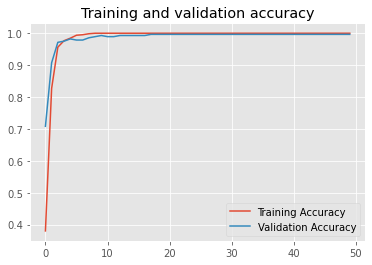

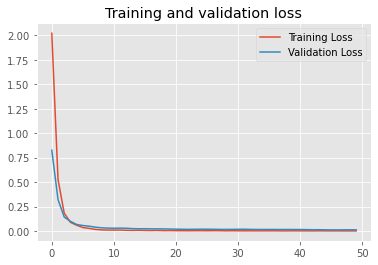

In [177]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[35  0  0  0  0  0  0]
 [ 0 42  0  0  0  0  0]
 [ 0  0 49  0  0  0  0]
 [ 0  0  0 40  0  0  0]
 [ 0  0  0  0 42  0  0]
 [ 0  0  0  0  1 29  0]
 [ 0  0  0  0  0  0 43]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.03 0.97 0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


C:\Users\intel\AppData\Local\Temp\ipykernel_3680\150913838.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


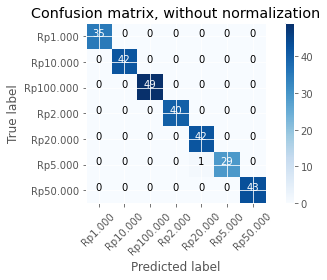

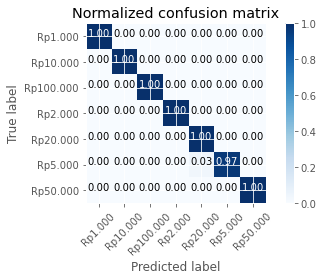

In [178]:
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = train_generator.class_indices.keys()

cm = confusion_matrix(validation_generator.classes, y_pred)

# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True, title='Normalized confusion matrix')

plt.show()

In [179]:
print('Classification Report')
# target_names = !cat labels.txt
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     Rp1.000       1.00      1.00      1.00        35
    Rp10.000       1.00      1.00      1.00        42
   Rp100.000       1.00      1.00      1.00        49
     Rp2.000       1.00      1.00      1.00        40
    Rp20.000       0.98      1.00      0.99        42
     Rp5.000       1.00      0.97      0.98        30
    Rp50.000       1.00      1.00      1.00        43

    accuracy                           1.00       281
   macro avg       1.00      1.00      1.00       281
weighted avg       1.00      1.00      1.00       281



In [180]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open ("Model/Mobilenetv2plusConv2d2V6.tflite" , "wb").write(tflite_model)

d:\Anaconda\envs\ds\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\intel\AppData\Local\Temp\tmp0_xdlpk7\assets


INFO:tensorflow:Assets written to: C:\Users\intel\AppData\Local\Temp\tmp0_xdlpk7\assets


11828856

In [181]:
model.save("Model/MyModel4")

d:\Anaconda\envs\ds\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: Model/MyModel4\assets


INFO:tensorflow:Assets written to: Model/MyModel4\assets


# Prune

In [21]:
import tensorflow_model_optimization as tfmot

In [155]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 5
validation_split = 0.3 # 10% of training set will be used for validation set. 

num_images = 923
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()

d:\Anaconda\envs\ds\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        4383708   
_________________________________________________________________
prune_low_magnitude_conv2d_9 (None, 5, 5, 32)          737314    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 2, 2, 32)          1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 2, 2, 32)          1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 128)               1         
_________________________________________________________________
prune_low_magnitude_dense_13 (None, 7)                 1801      
Total params: 5,122,826
Trainable params: 369,575
Non-trainable params: 4,753,251
_____________________________________

In [156]:
X,y = train_generator.next()

In [157]:
import tempfile

In [158]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X, y,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/5
1/1 [==============================] - 18s 18s/step - loss: 1.6996e-04 - accuracy: 1.0000 - val_loss: 3.8385e-06 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 9.4282e-06 - accuracy: 1.0000 - val_loss: 2.9564e-06 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 211ms/step - loss: 3.7711e-05 - accuracy: 1.0000 - val_loss: 2.9087e-06 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 184ms/step - loss: 1.0372e-04 - accuracy: 1.0000 - val_loss: 2.5988e-06 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 190ms/step - loss: 3.6560e-05 - accuracy: 1.0000 - val_loss: 2.5511e-06 - val_accuracy: 1.0000


In [159]:
X_t,y_t = validation_generator.next()

In [160]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   X_t, y_t, verbose=0)

print('Pruned test accuracy:', model_for_pruning_accuracy)

Pruned test accuracy: 1.0


In [161]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: C:\Users\intel\AppData\Local\Temp\tmpd8ygrnqw.h5


In [162]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

d:\Anaconda\envs\ds\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\intel\AppData\Local\Temp\tmpi0vyncmp\assets


INFO:tensorflow:Assets written to: C:\Users\intel\AppData\Local\Temp\tmpi0vyncmp\assets


Saved pruned TFLite model to: C:\Users\intel\AppData\Local\Temp\tmpk5s5ufkm.tflite


# Test

In [196]:
# Test
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
plt.style.use("ggplot")


def test (path,modelName):
    
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    # plt.show()

    x = image.img_to_array(img)/255
    x.resize(1, 224, 224, 3)
    

    interpreter = tf.lite.Interpreter(f"model/{modelName}.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]["index"], x)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])
    # print(output_data)
    # higehst_conf = max(output_data[0])
    # ix = np.where(output_data == higehst_conf)[-1][0]

    result = f"""
    1.000 Rupiah {(output_data[0][0]*100):.2f} %
    2.000 Rupiah {(output_data[0][3]*100):.2f} %
    5.000 Rupiah {(output_data[0][5]*100):.2f} %
    10.000 Rupiah {(output_data[0][1]*100):.2f} %
    20.000 Rupiah {(output_data[0][4]*100):.2f} %
    50.000 Rupiah {(output_data[0][6]*100):.2f} %
    100.000 Rupiah {(output_data[0][2]*100):.2f} %
    """

    # message = labels[ix]

    try:
        return result
    except Exception as e:
        return f"{e}"

In [201]:
data = [
    "Data/Rp1.000/0.jpg","Data/Rp1.000/10.jpg",
    "Data/Rp10.000/0.jpg","Data/Rp10.000/10.jpg",
    "Data/Rp20.000/0.jpg","Data/Rp20.000/10.jpg",
    "Data/Rp2.000/0.jpg","Data/Rp2.000/10.jpg",
    "Data/Rp5.000/27.jpg","Data/Rp5.000/37.jpg",
    "Data/Rp50.000/0.jpg","Data/Rp50.000/10.jpg",
    "Data/Rp100.000/0.jpg","Data/Rp100.000/10.jpg",
    "1.jpeg"
]


    1.000 Rupiah 99.96 %
    2.000 Rupiah 0.00 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 0.01 %
    20.000 Rupiah 0.04 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.00 %
    


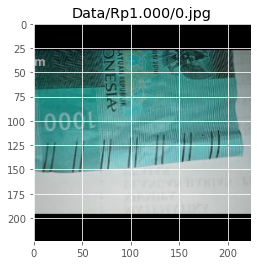


    1.000 Rupiah 99.76 %
    2.000 Rupiah 0.07 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 0.16 %
    20.000 Rupiah 0.00 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.00 %
    


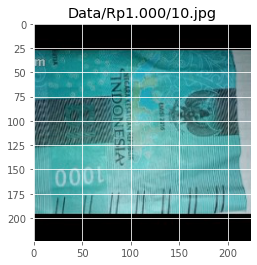


    1.000 Rupiah 0.01 %
    2.000 Rupiah 0.01 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 99.97 %
    20.000 Rupiah 0.00 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.01 %
    


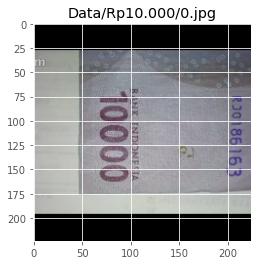


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.08 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 99.74 %
    20.000 Rupiah 0.17 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.00 %
    


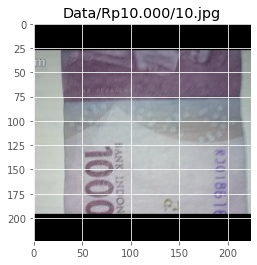


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.00 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 100.00 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.00 %
    


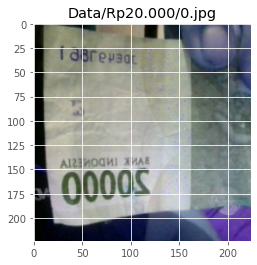


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.00 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 100.00 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.00 %
    


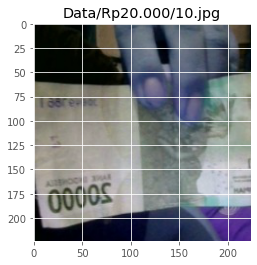


    1.000 Rupiah 0.02 %
    2.000 Rupiah 99.94 %
    5.000 Rupiah 0.01 %
    10.000 Rupiah 0.01 %
    20.000 Rupiah 0.01 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.02 %
    


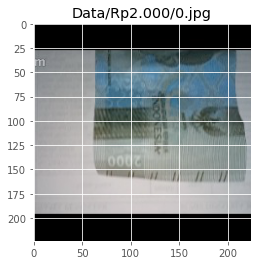


    1.000 Rupiah 0.02 %
    2.000 Rupiah 99.88 %
    5.000 Rupiah 0.01 %
    10.000 Rupiah 0.10 %
    20.000 Rupiah 0.00 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.00 %
    


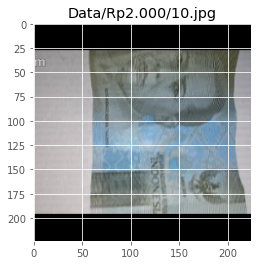


    1.000 Rupiah 0.01 %
    2.000 Rupiah 2.04 %
    5.000 Rupiah 88.54 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 0.02 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 9.39 %
    


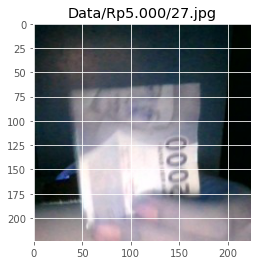


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.00 %
    5.000 Rupiah 100.00 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 0.00 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 0.00 %
    


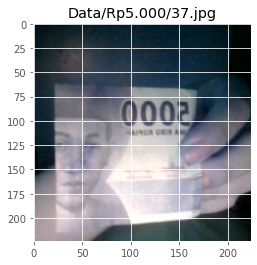


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.00 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 0.00 %
    50.000 Rupiah 99.82 %
    100.000 Rupiah 0.18 %
    


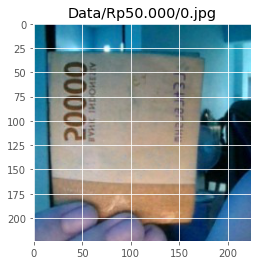


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.00 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 0.00 %
    50.000 Rupiah 99.95 %
    100.000 Rupiah 0.05 %
    


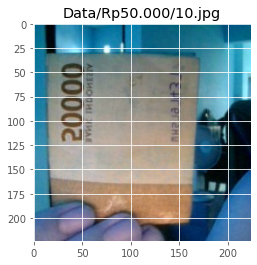


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.00 %
    5.000 Rupiah 0.00 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 0.00 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 100.00 %
    


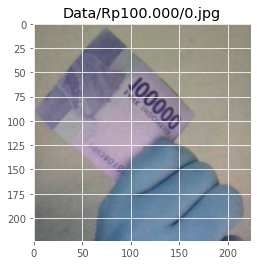


    1.000 Rupiah 0.00 %
    2.000 Rupiah 0.13 %
    5.000 Rupiah 0.09 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 1.95 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 97.82 %
    


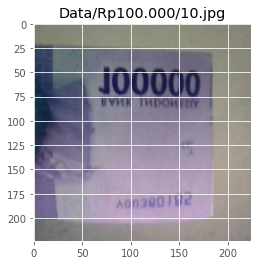


    1.000 Rupiah 0.02 %
    2.000 Rupiah 0.07 %
    5.000 Rupiah 0.01 %
    10.000 Rupiah 0.00 %
    20.000 Rupiah 0.01 %
    50.000 Rupiah 0.00 %
    100.000 Rupiah 99.90 %
    


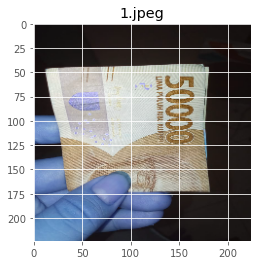

In [205]:
for path in data:
    # plt.imshow(path)
    print(test(path,"Mobilenetv2plusConv2d232Unit3x3FilterV2Pruned"))
    plt.title(path)
    plt.show()

InvalidArgumentError:  Input to reshape is a tensor with 64 values, but the requested shape requires a multiple of 256
	 [[node sequential_15/flatten_14/Reshape (defined at C:\Users\intel\AppData\Local\Temp\ipykernel_3680\514339904.py:11) ]] [Op:__inference_predict_function_882412]

Function call stack:
predict_function


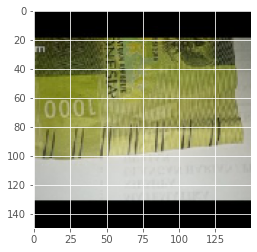

In [204]:
for fn in data:
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)/255
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(classes)